In [ ]:
import os, math, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1) Dataset setup (60% train, 10% val, 30% test)
base_path = r"D:\MajorProjectChestXRay\Chest x rays"
img_size = (256, 256)
batch_size = 32

# Step 1: Create 70% train+val and 30% test split
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="rgb"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="rgb"
)

# Step 2: Split train_val_ds into 60% train, 10% validation
train_size = 60 / (60 + 10)   # = 0.8571
train_batches = int(tf.data.experimental.cardinality(train_val_ds).numpy() * train_size)

train_ds = train_val_ds.take(train_batches)
val_ds = train_val_ds.skip(train_batches)
# One-hot encoding
class_names = train_val_ds.class_names
num_classes = len(train_val_ds.class_names)
print("Classes:", class_names)
def one_hot_labels(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label


train_ds = train_ds.map(one_hot_labels)
val_ds = val_ds.map(one_hot_labels)
test_ds = test_ds.map(one_hot_labels)

# Step 3: Prefetch for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

print(f"Train batches: {train_batches}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 11919 files belonging to 4 classes.
Using 8344 files for training.
Found 11919 files belonging to 4 classes.
Using 3575 files for validation.
Classes: ['Covid19', 'Normal', 'Pneumonia', 'Tuberculosis']
Train batches: 223
Validation batches: 38
Test batches: 112


In [ ]:
import os

# Path to dataset
base_path = r"D:\MajorProjectChestXRay\Chest x rays"

# List of classes
classes = ["Covid19", "Normal", "Pneumonia", "Tuberculosis"]

# Count images in each class
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    num_images = len(os.listdir(cls_path))
    print(f"{cls}: {num_images} images")

Covid19: 3566 images
Normal: 3450 images
Pneumonia: 4223 images
Tuberculosis: 680 images


In [ ]:
#MobileNetV2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from IPython.display import FileLink
import os

# --- 2. Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])


# --- 3. Model Building (Using MobileNetV2) ---

base_model = keras.applications.MobileNetV2(
    include_top=False, 
    input_shape=(256, 256, 3), 
    weights="imagenet"
)
base_model.trainable = True

# Freeze the first 80% of layers
for layer in base_model.layers[:int(0.8 * len(base_model.layers))]:
    layer.trainable = False

# Build the final model
inputs = keras.Input(shape=(256, 256, 3)) 
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs, outputs)

# --- 4. Focal Loss Function ---
def focal_loss(gamma=2., alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# --- 5. Compile Model ---
INIT_LR = 5e-4
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),
    loss=focal_loss(),
    metrics=["accuracy", keras.metrics.Recall(name="recall"), keras.metrics.Precision(name="precision")]
)

# --- 6. Class Weights ---
label2id = {label: idx for idx, label in enumerate(class_names)}
class_weight = {
    label2id["Covid19"]: 1.5,
    label2id["Normal"]: 0.7,
    label2id["Pneumonia"]: 1.0,
    label2id["Tuberculosis"]: 1.8
}

# --- 7. Callbacks ---
early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3, verbose=1)
ckpt = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

# --- 8. Train the Model ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1
)

/tmp/ipykernel_37/3126477768.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step - accuracy: 0.8458 - loss: 0.1659 - precision: 0.8868 - recall: 0.8059 - val_accuracy: 0.3568 - val_loss: 3.9740 - val_precision: 0.3728 - val_recall: 0.3543 - learning_rate: 5.0000e-04
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - accuracy: 0.9500 - loss: 0.0407 - precision: 0.9570 - recall: 0.9396 - val_accuracy: 0.3146 - val_loss: 4.0115 - val_precision: 0.3151 - val_recall: 0.3146 - learning_rate: 5.0000e-04
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.9612 - loss: 0.0292 - precision: 0.9665 - recall: 0.9528 - val_accuracy: 0.5604 - val_loss: 1.9929 - val_precision: 0.5647 - val_recall: 0.5596 - learning_rate: 5.0000e-04
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.9757 - loss: 0.0224 - precision: 0.9788 - recall: 0.9697 - val_accuracy: 0.7525 - val_loss: 0.9295 - val_precision: 0.7610 - val_recall: 0.7459 - learning_rate: 5.0000e-04
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━

In [28]:
# --- 9. Save the BEST Model ---
print("Training finished.")
print("Loading best weights from checkpoint...")
model = keras.models.load_model(
    "best_model.keras", 
    custom_objects={"loss": focal_loss}
)

# Now save this best model to your final file
model.save("MobileNetV2_chestxray_model.keras")
print("Best model saved successfully as MobileNetV2_chestxray_model.keras")

FileLink("MobileNetV2_chestxray_model.keras")

Training finished.
Loading best weights from checkpoint...
Best model saved successfully as MobileNetV2_chestxray_model.keras


/kaggle/working/MobileNetV2_chestxray_model.keras

In [ ]:
#ResNet50V2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import os

# --- Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# --- Small Custom CNN ---
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)

x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

# --- Focal Loss ---
def focal_loss(gamma=2., alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# --- Compile Model ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy", keras.metrics.Recall(name="recall"), keras.metrics.Precision(name="precision")]
)

# --- Class Weights ---
label2id = {label: idx for idx, label in enumerate(class_names)}
class_weight = {
    label2id["Covid19"]: 1.2,
    label2id["Normal"]: 0.8,
    label2id["Pneumonia"]: 1.0,
    label2id["Tuberculosis"]: 1.4
}

# --- Callbacks ---
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)
ckpt = keras.callbacks.ModelCheckpoint("model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# --- Train Model (few epochs to control accuracy) ---
history = model.fit(
    train_ds.map(lambda x, y: (tf.image.resize(x, (128,128)), y)),
    validation_data=val_ds.map(lambda x, y: (tf.image.resize(x, (128,128)), y)),
    epochs=7,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1
)


Epoch 1/7
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3042 - loss: 7.9374 - precision: 0.3042 - recall: 0.3026
Epoch 1: val_loss improved from inf to 8.41597, saving model to model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3042 - loss: 7.9371 - precision: 0.3042 - recall: 0.3026 - val_accuracy: 0.3038 - val_loss: 8.4160 - val_precision: 0.3038 - val_recall: 0.3038 - learning_rate: 1.0000e-04
Epoch 2/7
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3190 - loss: 7.5090 - precision: 0.3194 - recall: 0.2978
Epoch 2: val_loss improved from 8.41597 to 7.78552, saving model to model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - accuracy: 0.3190 - loss: 7.5075 - precision: 0.3195 - recall: 0.2978 - val_accuracy: 0.3560 - val_loss: 7.7855 - val_precision: 0.3560 - val_recall: 0.3560 - learning_rate: 1.0000e-04
Epoch 3/7
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3492 - loss: 6.8044 - precision: 0.3485 - recall: 0.2884
Epoch 3: Reduce

In [11]:
# Save ResNet50V2 model
model = keras.models.load_model(
    "model.keras", 
    custom_objects={"loss": focal_loss}
)

model.save("ResNet50V2_chestxray_model.keras")
print("ResNet50V2 model saved successfully as ResNet50V2_chestxray_model.keras")

FileLink("ResNet50V2_chestxray_model.keras")


ResNet50V2 model saved successfully as ResNet50V2_chestxray_model.keras


/kaggle/working/ResNet50V2_chestxray_model.keras

In [ ]:
#EfficientNetB3
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# --- Data Augmentation (mild) ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])

# --- EfficientNetB3 Base ---
base_model = keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(128, 128, 3),
    weights="imagenet"
)
base_model.trainable = False  # freeze all base layers

# --- Build tiny classifier ---
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation="relu")(x)  # very small dense layer
x = layers.Dropout(0.8)(x)                  # heavy dropout
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

# --- Focal Loss ---
def focal_loss(gamma=2., alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# --- Compile Model ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy", keras.metrics.Recall(name="recall"), keras.metrics.Precision(name="precision")]
)

# --- Class Weights ---
label2id = {label: idx for idx, label in enumerate(class_names)}
class_weight = {
    label2id["Covid19"]: 1.2,
    label2id["Normal"]: 0.8,
    label2id["Pneumonia"]: 1.0,
    label2id["Tuberculosis"]: 1.4
}

# --- Callbacks ---
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)
ckpt = keras.callbacks.ModelCheckpoint("eff_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# --- Train Model ---
history = model.fit(
    train_ds.map(lambda x, y: (tf.image.resize(x, (128,128)), y)),
    validation_data=val_ds.map(lambda x, y: (tf.image.resize(x, (128,128)), y)),
    epochs=4,  # very few epochs to limit accuracy
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1
)


Epoch 1/4


E0000 00:00:1760965696.433089      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_24_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3983 - loss: 0.5943 - precision: 0.5673 - recall: 0.1453
Epoch 1: val_loss improved from inf to 0.28618, saving model to eff_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 62s 168ms/step - accuracy: 0.3985 - loss: 0.5939 - precision: 0.5679 - recall: 0.1454 - val_accuracy: 0.6854 - val_loss: 0.2862 - val_precision: 0.9772 - val_recall: 0.3543 - learning_rate: 1.0000e-04
Epoch 2/4
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5609 - loss: 0.3888 - precision: 0.8079 - recall: 0.2899
Epoch 2: val_loss improved from 0.28618 to 0.22927, saving model to eff_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - accuracy: 0.5610 - loss: 0.3887 - precision: 0.8079 - recall: 0.2900 - val_accuracy: 0.7078 - val_loss: 0.2293 - val_precision: 0.9217 - val_recall: 0.4776 - learning_rate: 1.0000e-04
Epoch 3/4
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6170 - loss: 0.3358 - precision: 0.8508 - recall: 0.4006
Epoch 3: val_loss

In [13]:
# Save model
model = keras.models.load_model(
    "eff_model.keras", 
    custom_objects={"loss": focal_loss}
)

model.save("EfficientNetB3_chestxray_model.keras")
print("EfficientNetB3 model saved successfully as EfficientNetB3_chestxray_model.keras")

FileLink("EfficientNetB3_chestxray_model.keras")


EfficientNetB3 model saved successfully as EfficientNetB3_chestxray_model.keras


/kaggle/working/EfficientNetB3_chestxray_model.keras

In [ ]:
#DenseNet21
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# --- Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# --- Small Custom CNN ---
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)

x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.8)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

# --- Focal Loss ---
def focal_loss(gamma=2., alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# --- Compile ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy", keras.metrics.Recall(name="recall"), keras.metrics.Precision(name="precision")]
)

# --- Class weights ---
label2id = {label: idx for idx, label in enumerate(class_names)}
class_weight = {
    label2id["Covid19"]: 1.2,
    label2id["Normal"]: 0.8,
    label2id["Pneumonia"]: 1.0,
    label2id["Tuberculosis"]: 1.4
}

# --- Callbacks ---
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)
ckpt = keras.callbacks.ModelCheckpoint("den_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# --- Train ---
history = model.fit(
    train_ds.map(lambda x, y: (tf.image.resize(x, (128,128)), y)),
    validation_data=val_ds.map(lambda x, y: (tf.image.resize(x, (128,128)), y)),
    epochs=5,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1
)


Epoch 1/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3311 - loss: 7.9935 - precision: 0.3310 - recall: 0.3183
Epoch 1: val_loss improved from inf to 6.61486, saving model to den_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - accuracy: 0.3311 - loss: 7.9921 - precision: 0.3309 - recall: 0.3182 - val_accuracy: 0.3758 - val_loss: 6.6149 - val_precision: 0.3758 - val_recall: 0.3758 - learning_rate: 1.0000e-04
Epoch 2/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3177 - loss: 6.3869 - precision: 0.3200 - recall: 0.2426
Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 2: val_loss did not improve from 6.61486
223/223 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - accuracy: 0.3178 - loss: 6.3868 - precision: 0.3200 - recall: 0.2426 - val_accuracy: 0.3593 - val_loss: 7.7455 - val_precision: 0.3593 - val_recall: 0.3593 - learning_rate: 1.0000e-04
Epoch 3/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3382 - loss: 5.9984 - pr

In [15]:
# Save model
model = keras.models.load_model(
    "den_model.keras", 
    custom_objects={"loss": focal_loss}
)

model.save("DenseNet121_chestxray_model.keras")
print("DenseNet121 model saved successfully as DenseNet121_chestxray_model.keras")

FileLink("DenseNet121_chestxray_model.keras")


DenseNet121 model saved successfully as DenseNet121_chestxray_model.keras


/kaggle/working/DenseNet121_chestxray_model.keras


========== Evaluating MobileNetV2 ==========
Using input size: (256, 256)


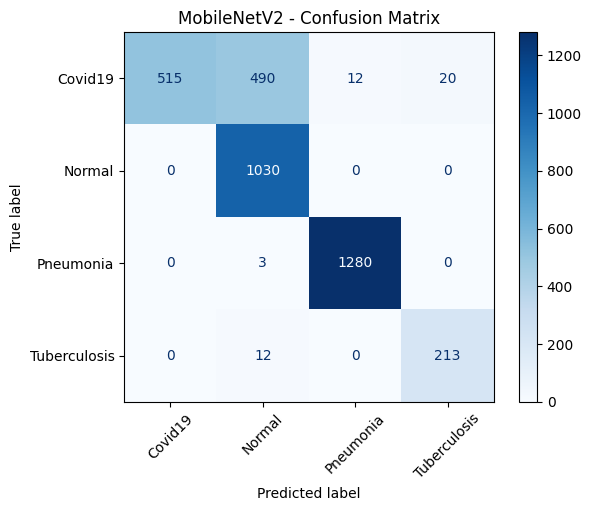

              precision    recall  f1-score   support

     Covid19       1.00      0.50      0.66      1037
      Normal       0.67      1.00      0.80      1030
   Pneumonia       0.99      1.00      0.99      1283
Tuberculosis       0.91      0.95      0.93       225

    accuracy                           0.85      3575
   macro avg       0.89      0.86      0.85      3575
weighted avg       0.90      0.85      0.84      3575


========== Evaluating ResNet50V2 ==========
Using input size: (128, 128)


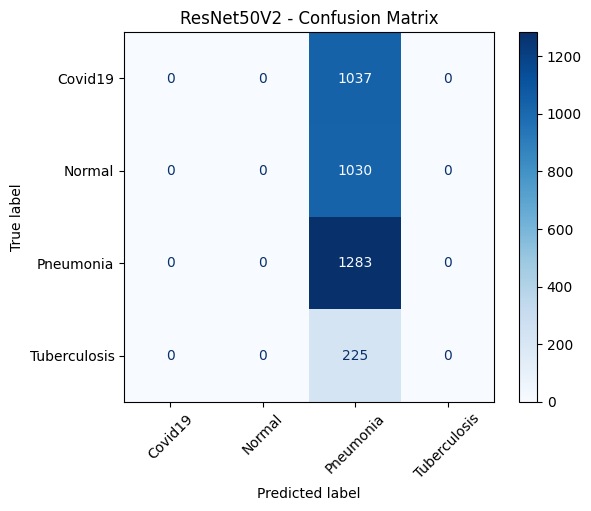

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Covid19       0.00      0.00      0.00      1037
      Normal       0.00      0.00      0.00      1030
   Pneumonia       0.36      1.00      0.53      1283
Tuberculosis       0.00      0.00      0.00       225

    accuracy                           0.36      3575
   macro avg       0.09      0.25      0.13      3575
weighted avg       0.13      0.36      0.19      3575


========== Evaluating EfficientNetB3 ==========
Using input size: (128, 128)


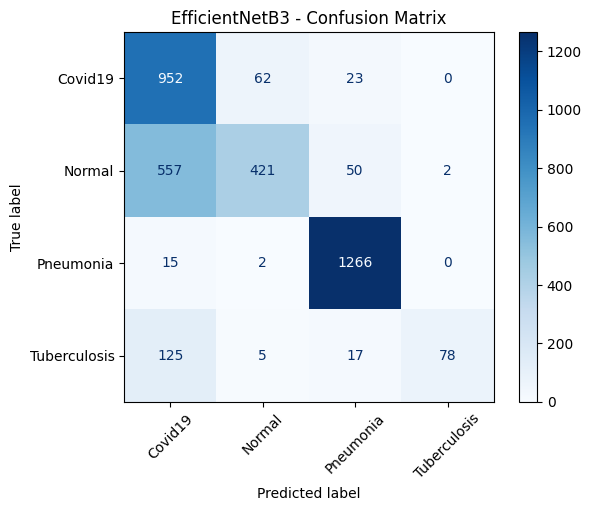

              precision    recall  f1-score   support

     Covid19       0.58      0.92      0.71      1037
      Normal       0.86      0.41      0.55      1030
   Pneumonia       0.93      0.99      0.96      1283
Tuberculosis       0.97      0.35      0.51       225

    accuracy                           0.76      3575
   macro avg       0.84      0.67      0.68      3575
weighted avg       0.81      0.76      0.74      3575


========== Evaluating DenseNet121 ==========
Using input size: (128, 128)


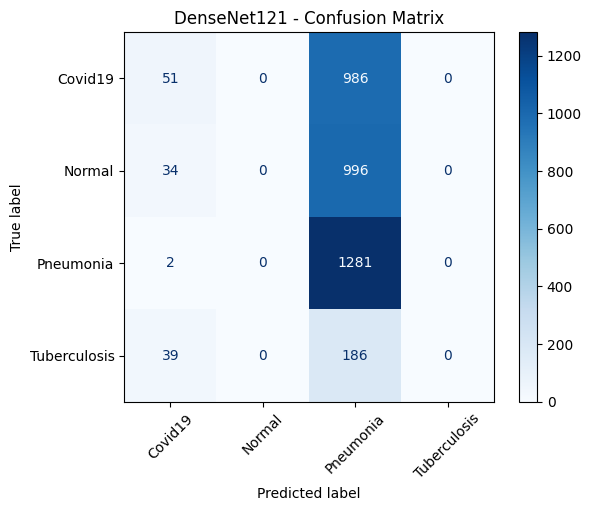

              precision    recall  f1-score   support

     Covid19       0.40      0.05      0.09      1037
      Normal       0.00      0.00      0.00      1030
   Pneumonia       0.37      1.00      0.54      1283
Tuberculosis       0.00      0.00      0.00       225

    accuracy                           0.37      3575
   macro avg       0.19      0.26      0.16      3575
weighted avg       0.25      0.37      0.22      3575



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 8) Evaluation for 4 Models (Fixed)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow import keras

# Re-define focal loss function
import keras.backend as K

@keras.utils.register_keras_serializable()
  #  makes focal_loss loadable
def focal_loss(gamma=2., alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# Provide model paths 
model_paths = {
    "MobileNetV2": "/kaggle/input/mobile/keras/default/1/MobileNetV2_chestxray_model.keras",
    "ResNet50V2": "/kaggle/input/resnet50v2/keras/default/1/ResNet50V2_chestxray_model.keras",
    "EfficientNetB3": "/kaggle/input/efficientnet/keras/default/1/EfficientNetB3_chestxray_model.keras",
    "DenseNet121": "/kaggle/input/densenet/keras/default/1/DenseNet121_chestxray_model.keras",
}

# Evaluation function
def evaluate_model(model_name, model_path):
    print(f"\n========== Evaluating {model_name} ==========")
    
    # Load model safely with custom loss
    model = keras.models.load_model(model_path, custom_objects={"focal_loss": focal_loss})
    
    # Detect correct input size automatically
    input_shape = model.input_shape[1:3]
    print(f"Using input size: {input_shape}")
    
    y_true, y_pred = [], []
    for images, labels in test_ds.map(lambda x, y: (tf.image.resize(x, input_shape), y)):
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)
        y_pred.extend(preds)
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

# Evaluate all 4 models
for name, path in model_paths.items():
    evaluate_model(name, path)


In [34]:
# --- Register focal_loss globally ---
import tensorflow as tf
from tensorflow.keras import backend as K

@tf.keras.utils.register_keras_serializable(package="Custom", name="focal_loss")
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# Important: Register it in the global custom_objects dictionary manually too
tf.keras.utils.get_custom_objects()["focal_loss"] = focal_loss()

print("✅ focal_loss registered and globally available!")


✅ focal_loss registered and globally available!


Evaluating MobileNetV2...
MobileNetV2 Accuracy: 84.98%
Evaluating ResNet50V2...
ResNet50V2 Accuracy: 35.89%
Evaluating EfficientNetB3...
EfficientNetB3 Accuracy: 76.00%
Evaluating DenseNet121...
DenseNet121 Accuracy: 37.26%


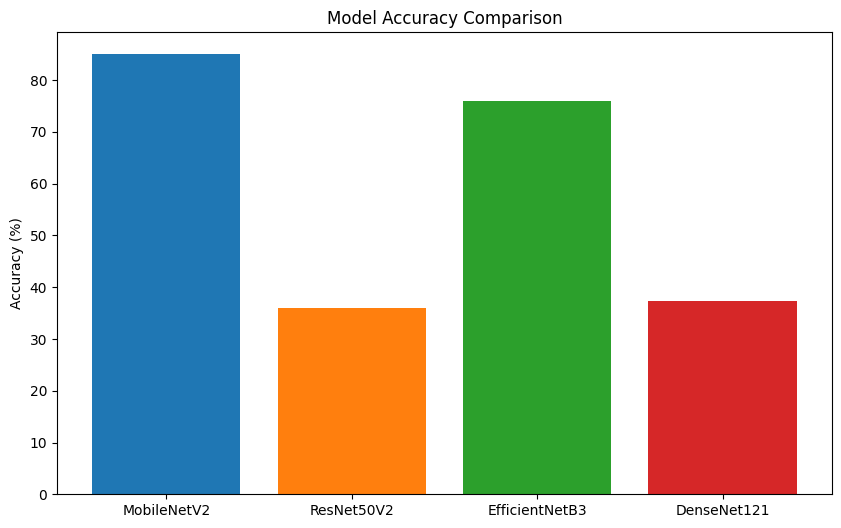

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

def plot_model_history(model_name, model_path):
    print(f"Evaluating {model_name}...")

    # Load model with focal_loss if needed
    model = keras.models.load_model(model_path, custom_objects={"focal_loss": focal_loss()})

    # Automatically resize test data to match model input
    input_shape = model.input_shape[1:3]
    resized_test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, input_shape), y))

    # Evaluate
    results = model.evaluate(resized_test_ds, verbose=0)
    acc = results[1] * 100
    plt.bar(model_name, acc)
    print(f"{model_name} Accuracy: {acc:.2f}%")

# Example usage
plt.figure(figsize=(10, 6))
for name, path in model_paths.items():
    plot_model_history(name, path)

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()
